<a href="https://colab.research.google.com/github/mohd-raza/Learning-Tensorflow/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



##Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)


In [1]:
!nvidia-smi

Fri Aug  5 11:47:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# downloading helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 


--2022-08-05 11:47:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-05 11:47:25 (101 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# importing helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [4]:
# 101 Food Classes: working with less data
# Our goal is to beat the original FOOD101 Paper with 10% of the training data

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2022-08-05 11:47:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.188.48, 172.217.13.80, 172.217.1.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.188.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   108MB/s    in 15s     

2022-08-05 11:47:43 (101 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/breakfast_burrito'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bruschetta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/edamame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/churros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/creme_brulee'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/club_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_carpaccio'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '1

In [7]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


##Train a big dog model with transfer learning on 10% of 101 food classes

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [8]:
# create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [9]:
# Create data augmentation layer to incorporate it right into the model
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential 

# Setup data augmentation
data_augmentation = Sequential([  
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNet50
], name="data_augmentation")

In [10]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3),name="input_layer")
x = data_augmentation(inputs)
x = base_model(x,training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), 
                      activation="softmax",
                      name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [11]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [12]:
# compile 
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data = test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 91s 315ms/step - loss: 3.4761 - accuracy: 0.2482 - val_loss: 2.6058 - val_accuracy: 0.4245
Epoch 2/5
237/237 [==============================] - 64s 268ms/step - loss: 2.3538 - accuracy: 0.4597 - val_loss: 2.2026 - val_accuracy: 0.4740
Epoch 3/5
237/237 [==============================] - 58s 243ms/step - loss: 1.9843 - accuracy: 0.5261 - val_loss: 2.0190 - val_accuracy: 0.4971
Epoch 4/5
237/237 [==============================] - 57s 238ms/step - loss: 1.7518 - accuracy: 0.5794 - val_loss: 1.9749 - val_accuracy: 0.4891
Epoch 5/5
237/237 [==============================] - 49s 205ms/step - loss: 1.5986 - accuracy: 0.6131 - val_loss: 1.8866 - val_accuracy: 0.5127


In [13]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results 

790/790 [==============================] - 81s 103ms/step - loss: 1.7313 - accuracy: 0.5462


[1.7312636375427246, 0.5462177991867065]

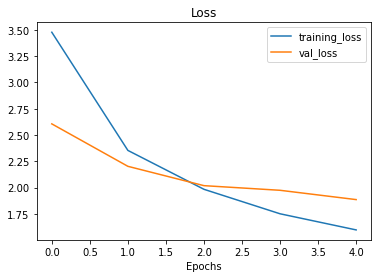

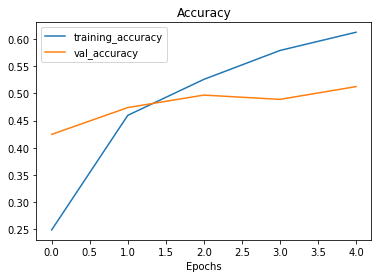

In [14]:
plot_loss_curves(history_all_classes_10_percent)

###Fine-Tuning

In [15]:
base_model.trainable = True
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [16]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

In [17]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [18]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [19]:
# Fine-tune for 5 epochs 
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# fine-tune our model
history_all_classes_fine_tune = model.fit(train_data_all_10_percent,
                                          epochs=fine_tune_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.15*len(test_data)),
                                          initial_epoch=history_all_classes_10_percent.epoch[-1],
                                          )

Epoch 5/10
237/237 [==============================] - 69s 247ms/step - loss: 1.3697 - accuracy: 0.6455 - val_loss: 1.8765 - val_accuracy: 0.5050
Epoch 6/10
237/237 [==============================] - 54s 223ms/step - loss: 1.2434 - accuracy: 0.6690 - val_loss: 1.8771 - val_accuracy: 0.5048
Epoch 7/10
237/237 [==============================] - 49s 207ms/step - loss: 1.1527 - accuracy: 0.6919 - val_loss: 1.8385 - val_accuracy: 0.5172
Epoch 8/10
237/237 [==============================] - 48s 196ms/step - loss: 1.0908 - accuracy: 0.7142 - val_loss: 1.9230 - val_accuracy: 0.4984
Epoch 9/10
237/237 [==============================] - 39s 163ms/step - loss: 1.0340 - accuracy: 0.7204 - val_loss: 1.8480 - val_accuracy: 0.5159
Epoch 10/10
237/237 [==============================] - 38s 159ms/step - loss: 0.9704 - accuracy: 0.7410 - val_loss: 1.8527 - val_accuracy: 0.5138


In [20]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 64s 81ms/step - loss: 1.6279 - accuracy: 0.5732


[1.6278961896896362, 0.5732277035713196]

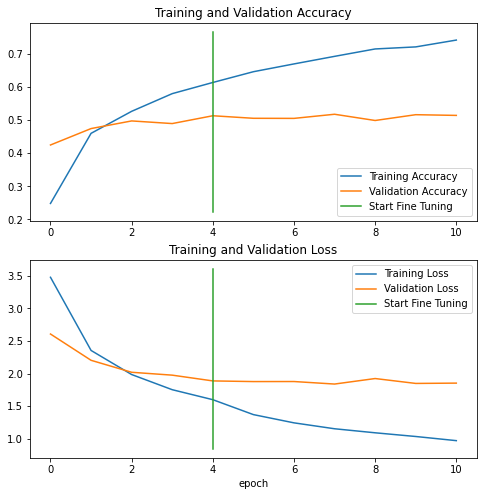

In [21]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_fine_tune,
                 initial_epochs=5)

In [22]:
# Save our fine-tuning model
model.save("drive/MyDrive/Tensorflow/101_food_classes_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: drive/MyDrive/Tensorflow/101_food_classes_10_percent_saved_big_dog_model/assets


In [23]:
# load and evaluate the saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/Tensorflow/101_food_classes_10_percent_saved_big_dog_model")

In [24]:
# Evaluate loaded model and compare perfomance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 86s 107ms/step - loss: 1.6279 - accuracy: 0.5732


[1.6278961896896362, 0.5732277035713196]

In [25]:
all_classes_10_percent_fine_tune_results

[1.6278961896896362, 0.5732277035713196]

###Evaluating the performance of the big dog model across all different classes
Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [26]:
import tensorflow as tf

# Download pretrained model (one that was prepared earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-08-05 12:06:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 172.253.63.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   104MB/s    in 0.4s    

2022-08-05 12:06:21 (104 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [27]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [28]:
# Load in the saved model
model = tf.keras.models.load_model('/content/06_101_food_class_10_percent_saved_big_dog_model')

In [29]:
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 85s 105ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

###Making predictions with our trained model


In [30]:
pred_probs = model.predict(test_data, verbose=1) # see verbosity to see how long is left 

790/790 [==============================] - 83s 102ms/step


In [31]:
len(test_data)

790

In [32]:
# how many predictions are there
len(pred_probs)

25250

In [33]:
pred_probs.shape

(25250, 101)

In [34]:
# let's see what each preds look like
pred_probs[0]

array([5.9541997e-02, 3.5742044e-06, 4.1377008e-02, 1.0660534e-09,
       8.1614111e-09, 8.6639478e-09, 8.0927191e-07, 8.5652403e-07,
       1.9859070e-05, 8.0977674e-07, 3.1727800e-09, 9.8673911e-07,
       2.8532185e-04, 7.8049184e-10, 7.4230076e-04, 3.8916409e-05,
       6.4740357e-06, 2.4977301e-06, 3.7891128e-05, 2.0678326e-07,
       1.5538435e-05, 8.1507017e-07, 2.6230514e-06, 2.0010684e-07,
       8.3827518e-07, 5.4216030e-06, 3.7390816e-06, 1.3150530e-08,
       2.7761480e-03, 2.8051860e-05, 6.8562017e-10, 2.5574853e-05,
       1.6688880e-04, 7.6406842e-10, 4.0452872e-04, 1.3150632e-08,
       1.7957391e-06, 1.4448174e-06, 2.3062943e-02, 8.2466846e-07,
       8.5365838e-07, 1.7138658e-06, 7.0525025e-06, 1.8402130e-08,
       2.8553373e-07, 7.9483443e-06, 2.0681568e-06, 1.8525114e-07,
       3.3619767e-08, 3.1522580e-04, 1.0410922e-05, 8.5448272e-07,
       8.4741855e-01, 1.0555444e-05, 4.4094620e-07, 3.7404177e-05,
       3.5306122e-05, 3.2489035e-05, 6.7314730e-05, 1.2852565e

In [35]:
sum(pred_probs[0])

1.000000060049003

In [36]:
#  We get one prediction prob per class
print(f"Number of prediction probabilities for Sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")


Number of prediction probabilities for Sample 0: 101
What prediction probability sample 0 looks like:
 [5.9541997e-02 3.5742044e-06 4.1377008e-02 1.0660534e-09 8.1614111e-09
 8.6639478e-09 8.0927191e-07 8.5652403e-07 1.9859070e-05 8.0977674e-07
 3.1727800e-09 9.8673911e-07 2.8532185e-04 7.8049184e-10 7.4230076e-04
 3.8916409e-05 6.4740357e-06 2.4977301e-06 3.7891128e-05 2.0678326e-07
 1.5538435e-05 8.1507017e-07 2.6230514e-06 2.0010684e-07 8.3827518e-07
 5.4216030e-06 3.7390816e-06 1.3150530e-08 2.7761480e-03 2.8051860e-05
 6.8562017e-10 2.5574853e-05 1.6688880e-04 7.6406842e-10 4.0452872e-04
 1.3150632e-08 1.7957391e-06 1.4448174e-06 2.3062943e-02 8.2466846e-07
 8.5365838e-07 1.7138658e-06 7.0525025e-06 1.8402130e-08 2.8553373e-07
 7.9483443e-06 2.0681568e-06 1.8525114e-07 3.3619767e-08 3.1522580e-04
 1.0410922e-05 8.5448272e-07 8.4741855e-01 1.0555444e-05 4.4094620e-07
 3.7404177e-05 3.5306122e-05 3.2489035e-05 6.7314730e-05 1.2852565e-08
 2.6219704e-10 1.0318108e-05 8.5744112e-05 1.

In [37]:
test_data.class_names[52]

'gyoza'

In [38]:
# get the pred classes of each label
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [39]:
# To get our test labels we need to unravel
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where the "1" occurs
y_labels[:10] # look at the first 10 


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

###Evaluating our model's predictions
One way to check that our model's predictions array (pred_classes) is in the same order as our test labels array (y_labels) is to find the accuracy score.

In [40]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [41]:
# let's try scikit-learn's accuracy score function and see what it comes to this
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels,pred_classes)
sklearn_accuracy

0.6077623762376237

In [42]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

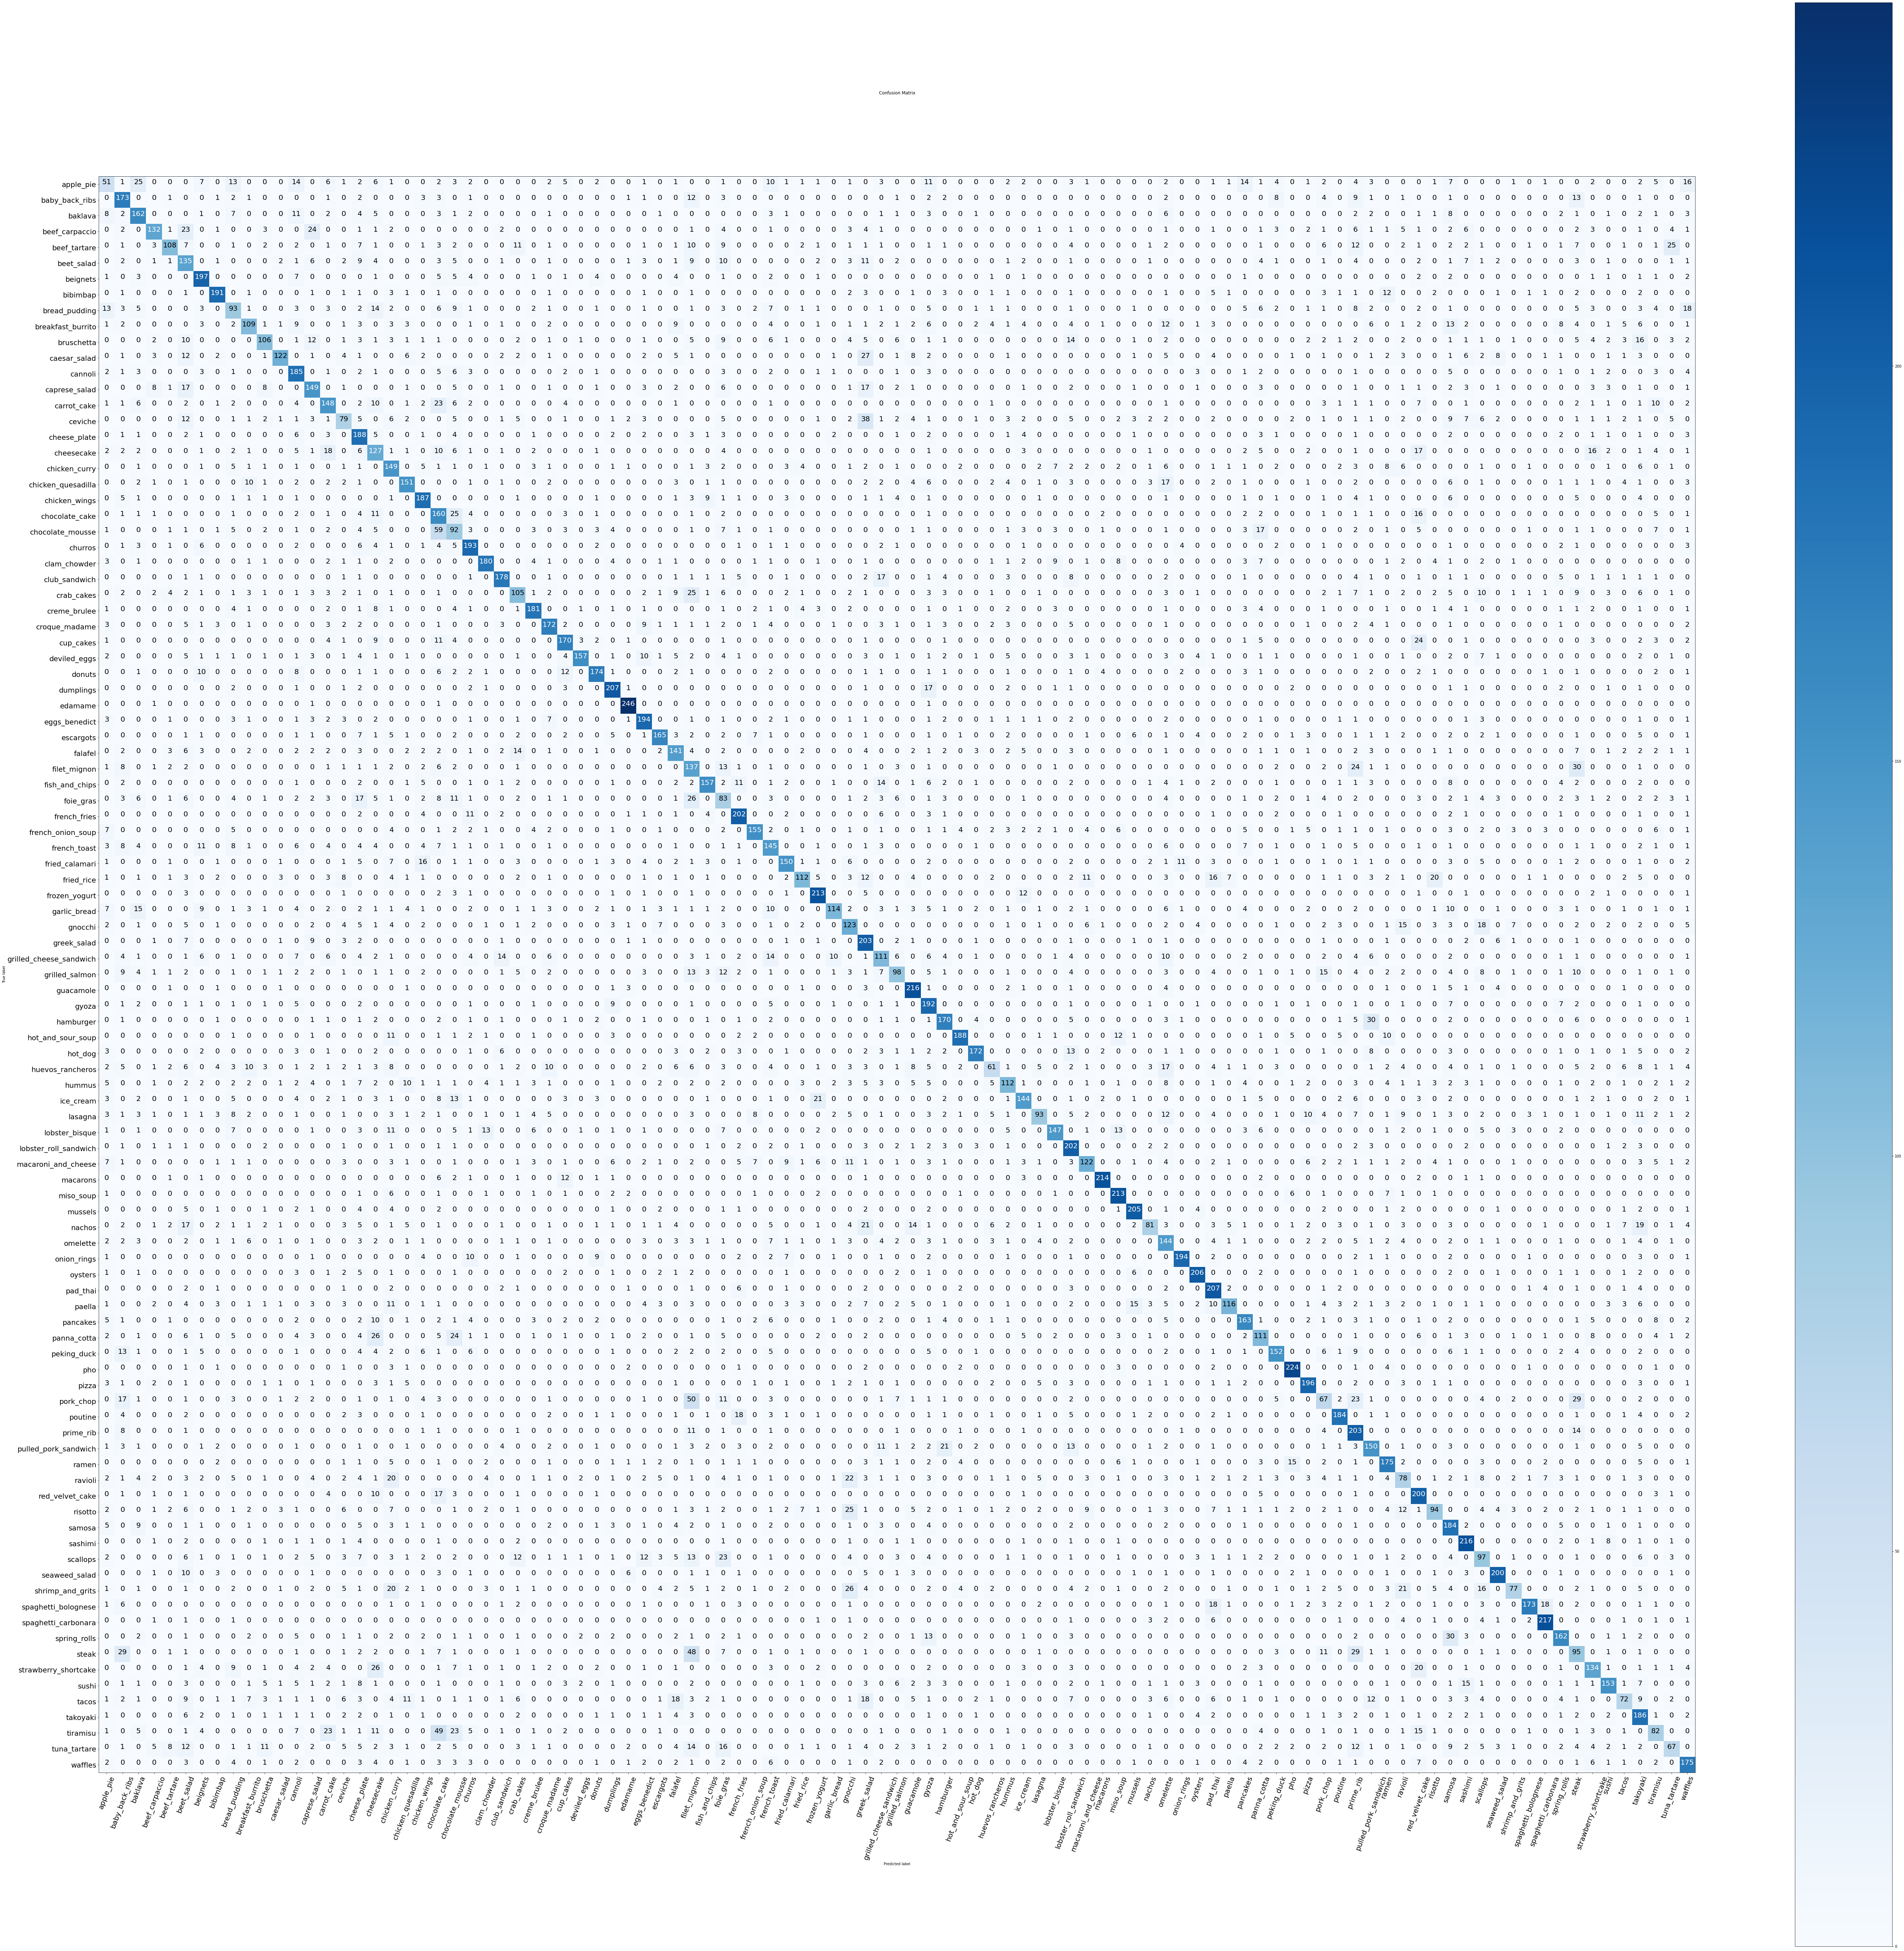

In [43]:
class_names = test_data.class_names
make_confusion_matrix(y_labels,pred_classes,class_names,figsize=(100,100),
                      text_size=20,savefig=True)

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [45]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

In [46]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [47]:
# Trun f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

In [48]:
f1_scores[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

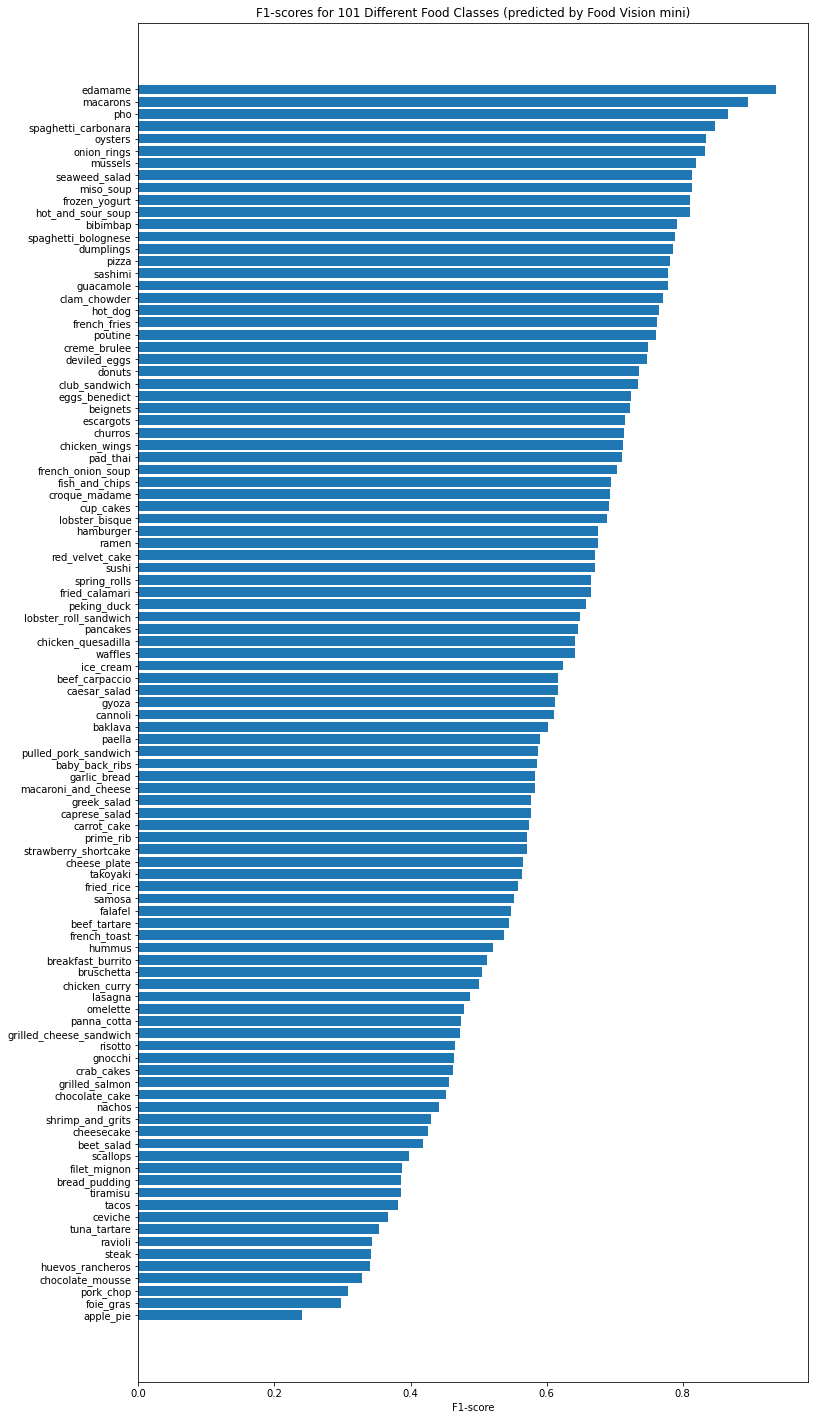

In [49]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini)")
ax.invert_yaxis(); # reverse the order of our plot

# Challenge: add values to the end of each bar of what the actual f1-score is 
# (hint: use the "autolabel" function from here: https://matplotlib.org/2.0.2/examples/a

###Visualizing predictions on test images

In [52]:
# create a function to load and prepare images
def load_and_prep_image(filename,img_shape=224,scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not
  
  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # read in the image
  img = tf.io.read_file(filename)

  # decode image into tensor
  img = tf.io.decode_image(img,channels=3,)

  # resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  
  # Scale
  if scale:
    # rescale the image(get all the values between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet Models in TF4

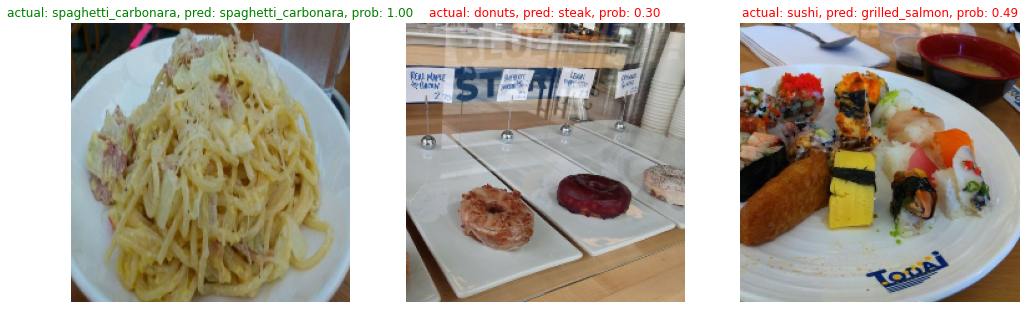

In [77]:
# let's visualize images, their target label and our model's predictions.

import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename
  # print(filepath)

  # load the image and make predictions
  img = load_and_prep_image(filepath,scale=False)
  img_expanded = tf.expand_dims(img,axis=0)
  pred_prob = model.predict(img_expanded)
  pred_class = class_names[pred_prob.argmax()]

  # plot the images
  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:  # if pred class matches truth class make text green
    title_color='g'
  else:
    title_color='r'
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}",c=title_color)
  plt.axis(False)

## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:

* Get all of the image file paths in the test dataset using list_files() method
* Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.
* Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
* Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
* Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [79]:
# 1. Get all the images file paths in test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [84]:
# 2. Create a Datafram of diff paramter for each of our test images
import pandas as pd

pred_df = pd.DataFrame({
    "img_path":filepaths,
    "y_true":y_labels,
    "y_pred":pred_classes,
    "pred_conf":pred_probs.max(axis=1),
    "y_true_classname": [class_names[i] for i in y_labels],
    "y_pred_classname": [class_names[i] for i in pred_classes]})

In [85]:
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847419        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658607        apple_pie  pulled_pork_sandwich  
4       0.367901        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878028          waffles          cheese_plate  
25247   0.537899          waffles               waffles  
25248   0.501950          waffles  strawberry_shortcake  
25249   0.690629          waffles               waffles  

[25250 rows x 6 columns]

In [86]:
# 3. Find out the DF which prediction are wrong
pred_df["pred_correct"] = pred_df['y_true'] == pred_df['y_pred'] 
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      52   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      80   
4  b'/content/101_food_classes_10_percent/test/ap...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847419        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658607        apple_pie  pulled_pork_sandwich         False  
4   0.367901        apple_pie             prime_rib         False

In [87]:
# 4. Sort out DF to have most wrong prediction at the top

top_100_wrong = pred_df[pred_df['pred_correct'] == False].sort_values('pred_conf',ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   
24540  b'/content/101_food_classes_10_percent/test/ti...      98      83   
2511   b'/content/101_food_classes_10_percent/test/br...      10      61   
5574   b'/content/101_food_classes_10_percent/test/ch...      22      21   
17855  b'/content/101_food_classes_10_percent/test/pa...      71      65   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
18001  b'/content/101_food_classes_10_percent/test/pa...      72      67   
11642  b'/content/101_food_classes_10_percent/test/ga...      46      10   
10847  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23631  b'/content/101_food_classes_10_percent/test/st...      94      83   
1155   b'/content/101_food_classes_10_percent/test/be...       4       5   
10854  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23904  b'/content/101_food_classes_10_percent/test/su...      95      86   
7316   b'/content/101_food_classes_10_percent/test/cu...      29      83   
13144  b'/content/101_food_classes_10_percent/test/gy...      52      92   
10880  b'/content/101_food_classes_10_percent/test/fr...      43      68   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

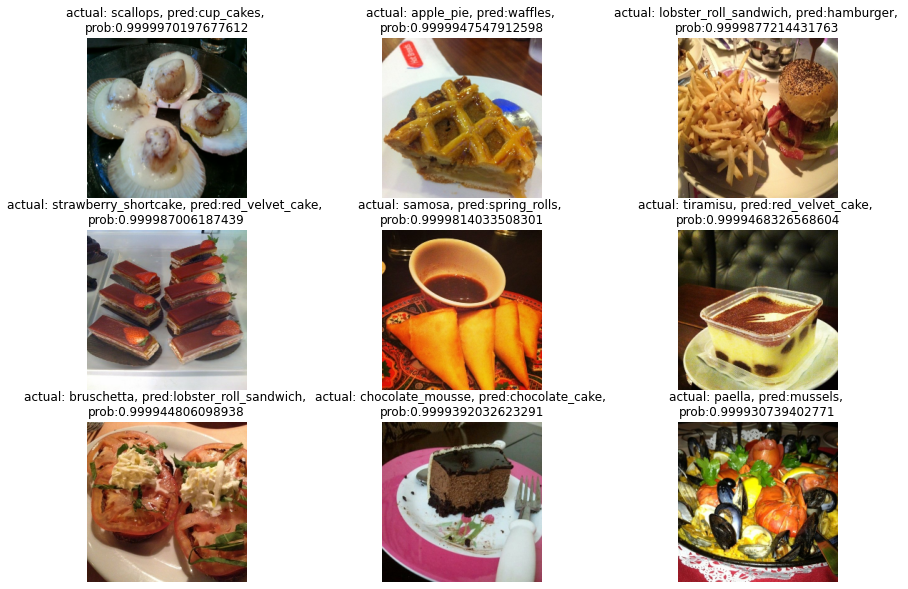

In [90]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability
image_to_view = 9
start_index = 0
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+image_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img = load_and_prep_image(row[1],scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred:{y_pred_classname}, \nprob:{pred_prob}")
  plt.axis(False)

###Test out the big dog model on our own custom images


In [91]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2022-08-05 12:44:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.81.208, 172.217.13.80, 142.251.45.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.81.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  49.0MB/s    in 0.3s    

2022-08-05 12:44:01 (49.0 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [92]:
# Get the custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg']

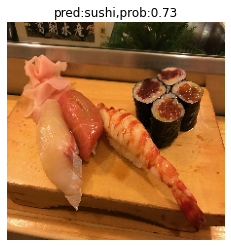

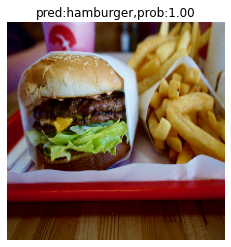

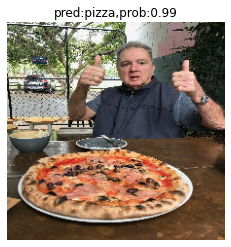

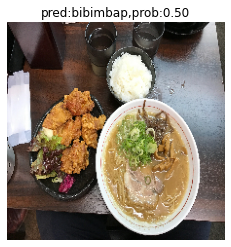

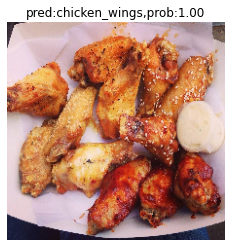

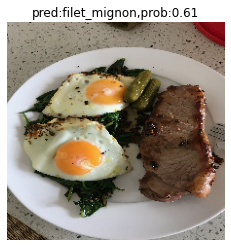

In [94]:
# Make pred on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img,scale=False)
  pred_prob = model.predict(tf.expand_dims(img,axis=0))
  pred_class = class_names[pred_prob.argmax()]
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred:{pred_class},prob:{pred_prob.max():.2f}")
  plt.axis(False)